**Q3**

Imports for this part:

In [1]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import ast
from collections import Counter
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel
import statsmodels.api as sm 

#import re 
#from bs4 import BeautifulSoup 
#from datetime import datetime
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#import ast

Get the dataset:

In [2]:
folder = "generated/"

df_movies=pd.read_csv(folder + "USE_THIS_DATASET.csv", index_col = 'Wikipedia movie ID')
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

Keep what is usefull for this part and save it to a csv file:

In [9]:
# keep what is usefull for part 3
df_3 = df_movies.copy()

df_3 = df_3.drop(['Movie release month', 'Movie release date', 'Movie runtime', 'Movie languages', 'Compound Score'], axis=1)

df_3 = df_3.dropna(subset=['Movie box office revenue','Movie release year'])

df_3['Movie release year'] = df_3['Movie release year'].astype(int)

# Convert string representations of lists into actual lists
df_3['Movie countries'] = df_3['Movie countries'].apply(ast.literal_eval)
df_3['Movie genres'] = df_3['Movie genres'].apply(ast.literal_eval)

#df_3 = df_3[df_3['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [5]:
#Get rid of Box office oulier
threshold = df_3['Movie box office revenue'].quantile(0.99)
df_3 = df_3[df_3['Movie box office revenue'] <= threshold]

In [6]:
#Themes correction

df_3['Theme'] = df_3['Theme'].str.lower()

corrections = { 
    "ransformation": "transformation",
    "ransition": "transition",
    "ptation": "temptation",
    "ragedy": "tragedy",
    "ranscendence": "transcendence",
    "radition": "tradition",
    "ransport": "transport",
    "ransgression": "transgression",
    "ransmutation": "transmutation",
    "ransparency": "transparency",
    "ransportation": "transportation",
    "ransmigration": "transmigration",
    "rture": "torture",
    "rritory": "territory",
    "rafficking": "trafficking",
    "vriendschap": "friendship",
    "vengeance": "revenge" #grouping for analysis
}

# Function to correct themes
def correct_theme(theme):
    if pd.isna(theme):  # Handle NaN values
        return theme
    return corrections.get(theme, theme)  # Apply correction if it exists

# Apply the correction to the 'Theme' column
df_3['Corrected_Theme'] = df_3['Theme'].apply(correct_theme)

In [7]:
df_3 = df_3.drop(['Theme'], axis = 1) 

In [8]:
# Save to a csv file
df_3.to_csv('df_3_.csv')

In [10]:
# Useful functions

# Function to calculate confidence intervals 
def calculate_ci(data, confidence=0.99):
    # Calculate the standard error of the mean (SEM)
    sem = stats.sem(data, nan_policy='omit')
    # Calculate the margin of error
    margin_of_error = sem * stats.t.ppf((1 + confidence) / 2., len(data)-1)
    return margin_of_error

In [17]:
# Useful general objects

movies_per_year = df_3.groupby('Movie release year').size()

box_office_per_year = df_3.groupby('Movie release year')['Movie box office revenue'].mean()

# Calculate CI for total movies per year
movies_per_year_ci_upper = movies_per_year + calculate_ci(movies_per_year)
movies_per_year_ci_lower = movies_per_year - calculate_ci(movies_per_year)

all_movies_revenue_stats = df_3['Movie box office revenue'].describe()

**War-related movies**

In [12]:
#War related movies

# List of genres related to LGBT themes
war_genres = [
    'War film', 'Combat films', 'Anti-War film', 'Gulf War', 'Cold War', 'Nuclear warfare', 'War effort', 'Anti-war'
]

# Create a binary column: 1 for war-related movies, 0 for non-war movies
df_3['War Related'] = df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))

war_movies = df_3[df_3['Movie genres'].apply(lambda genres: any(g in genres for g in war_genres))]

In [27]:
print(f"Number of War Movies: {len(war_movies)}")
war_movies.info()

Number of War Movies: 545
<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 171005 to 1142326
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                545 non-null    object 
 1   Movie release year        545 non-null    int64  
 2   Movie box office revenue  545 non-null    float64
 3   Movie countries           545 non-null    object 
 4   Movie genres              545 non-null    object 
 5   Summary                   538 non-null    object 
 6   Sentiment                 538 non-null    object 
 7   Theme                     535 non-null    object 
 8   vote_average              494 non-null    float64
 9   budget                    317 non-null    float64
 10  decade                    545 non-null    float64
 11  War Related               545 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 51.6+ KB


In [14]:
# Save to a csv file
war_movies.to_csv('war_movies_.csv')

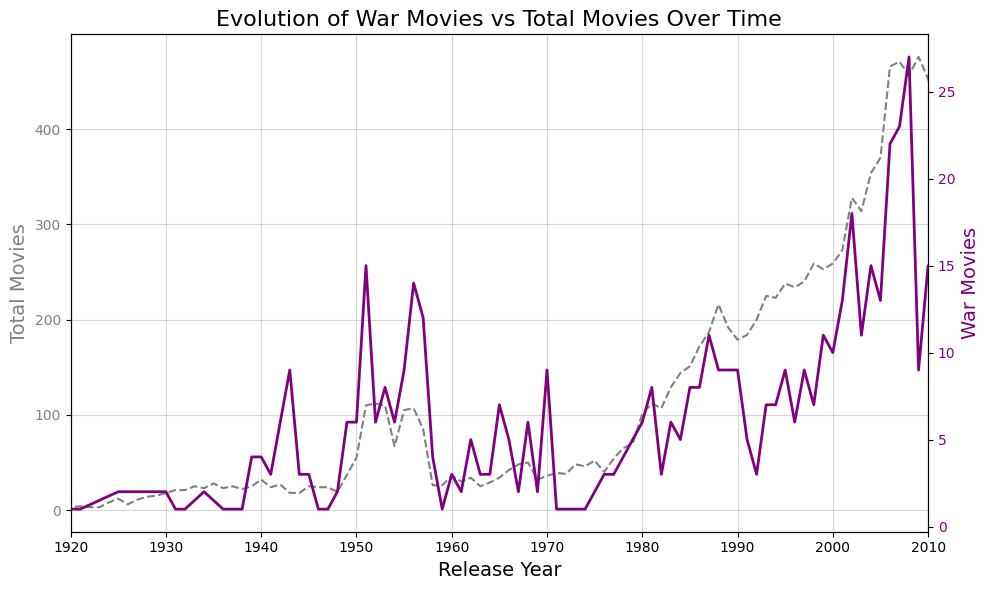

In [15]:
# Group by release year and count movies
war_movies_per_year = war_movies.groupby('Movie release year').size()


# Plot the number of War-related movies released over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot total movies
ax1.plot(movies_per_year.index, movies_per_year.values, color='gray', linestyle='--', label='Total Movies')
ax1.set_xlabel('Release Year', fontsize=14)
ax1.set_ylabel('Total Movies', fontsize=14, color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot LGBT movies
ax2 = ax1.twinx()
ax2.plot(war_movies_per_year.index, war_movies_per_year.values, color='purple', linewidth=2, label='LGBT Movies')
ax2.set_ylabel('War Movies', fontsize=14, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Evolution of War Movies vs Total Movies Over Time', fontsize=16)
ax1.set_xlim(1920, 2010)
ax1.grid(alpha=0.5)

plt.tight_layout()
#plt.savefig('visuals/NbWarMovies_ReleaseYear.png')
plt.show()

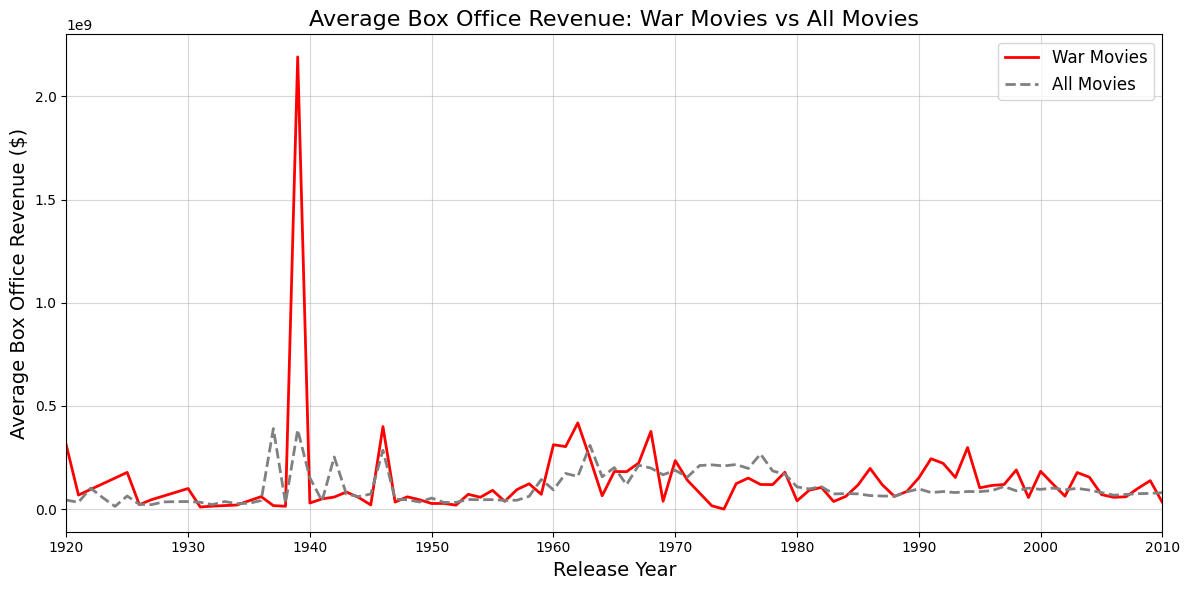

In [20]:
# Group by year and calculate average box office revenue for war movies
war_movies_box_office_per_year = war_movies.groupby('Movie release year')['Movie box office revenue'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_per_year.index, war_movies_box_office_per_year.values, label='War Movies', color='red', linewidth=2)
plt.plot(box_office_per_year.index, box_office_per_year.values, label='All Movies', color='gray', linestyle='--', linewidth=2)
plt.title('Average Box Office Revenue: War Movies vs All Movies', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Box Office Revenue ($)', fontsize=14)
plt.xlim(1920, 2010)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


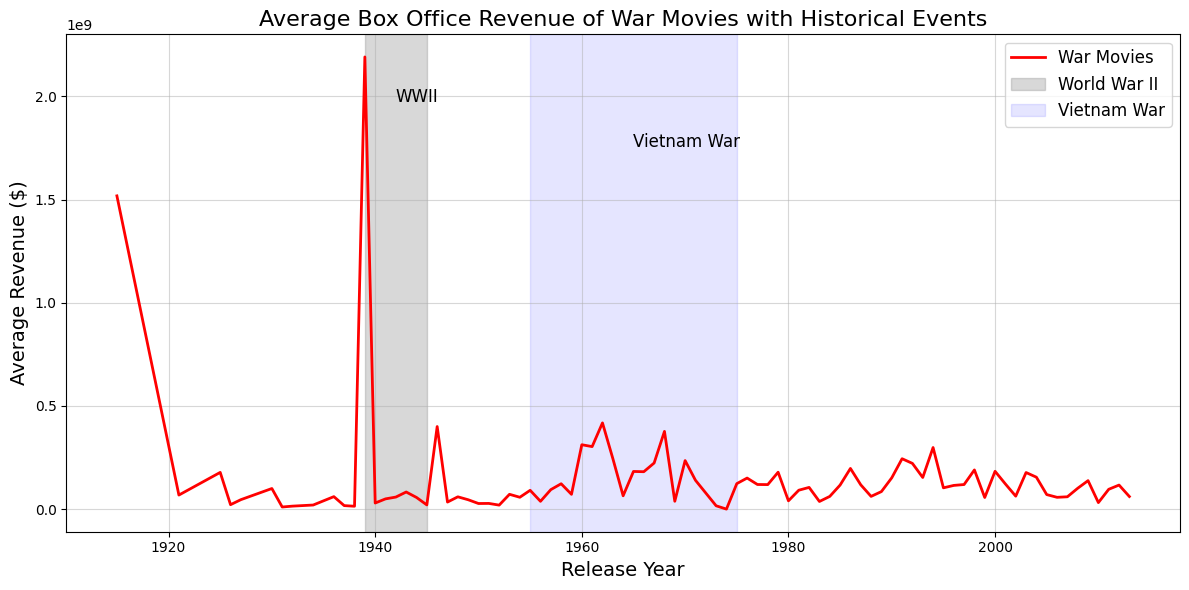

In [21]:
# Example of annotating World War II and Vietnam War
plt.figure(figsize=(12, 6))
plt.plot(war_movies_box_office_per_year.index, war_movies_box_office_per_year.values, label='War Movies', color='red', linewidth=2)

# Annotate World War II (1939-1945)
plt.axvspan(1939, 1945, color='gray', alpha=0.3, label='World War II')
plt.text(1942, max(war_movies_box_office_per_year) * 0.9, 'WWII', color='black', fontsize=12)

# Annotate Vietnam War (1955-1975)
plt.axvspan(1955, 1975, color='blue', alpha=0.1, label='Vietnam War')
plt.text(1965, max(war_movies_box_office_per_year) * 0.8, 'Vietnam War', color='black', fontsize=12)

plt.title('Average Box Office Revenue of War Movies with Historical Events', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Average Revenue ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


In [29]:
# Group by release year
war_movies_trends = war_movies.groupby('Movie release year').agg(
    num_movies=('Movie name', 'count'),
    avg_revenue=('Movie box office revenue', 'mean'),
    avg_rating=('vote_average', 'mean')
).reset_index()

# Display the first few rows
print(war_movies_trends.head())


   Movie release year  num_movies   avg_revenue  avg_rating
0                1915           1  1.517601e+09       6.034
1                1921           1  6.830297e+07       6.934
2                1925           2  1.780915e+08       7.608
3                1926           2  2.169078e+07       6.941
4                1927           2  4.600422e+07       7.205


In [31]:
war_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 171005 to 1142326
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie name                545 non-null    object 
 1   Movie release year        545 non-null    int64  
 2   Movie box office revenue  545 non-null    float64
 3   Movie countries           545 non-null    object 
 4   Movie genres              545 non-null    object 
 5   Summary                   538 non-null    object 
 6   Sentiment                 538 non-null    object 
 7   Theme                     535 non-null    object 
 8   vote_average              494 non-null    float64
 9   budget                    317 non-null    float64
 10  decade                    545 non-null    float64
 11  War Related               545 non-null    bool   
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 51.6+ KB


**Matched study**

In [65]:
# Replace empty strings with 'Unknown' in 'Movie countries'
df_3['Movie countries'] = df_3['Movie countries'].apply(
    lambda x: ['Unknown country' if country == '' else country for country in x] if isinstance(x, list) else x
)

# Replace empty strings with 'Unknown' in 'Movie genres'
df_3['Movie genres'] = df_3['Movie genres'].apply(
    lambda x: ['Unknown genre' if genre == '' else genre for genre in x] if isinstance(x, list) else x
)


In [84]:
# Drop rows with missing budget data
df_matching = df_3.dropna(subset=['budget']).copy()


# Verification: Check the number of remaining movies
print(f"Number of movies after dropping missing budgets: {len(df_matching)}")

Number of movies after dropping missing budgets: 6046


In [85]:
# One-hot encode 'Movie countries'
df_encoded_countries = pd.get_dummies(df_matching['Movie countries'].explode()).groupby(level=0).max()

# Add the encoded countries back to the dataset
df_matching = pd.concat([df_matching, df_encoded_countries], axis=1)

# One-hot encode 'Movie genres'
df_encoded_genres = pd.get_dummies(df_matching['Movie genres'].explode()).groupby(level=0).max()

# Add encoded genres back to the dataset
df_matching = pd.concat([df_matching, df_encoded_genres], axis=1)

In [93]:
# Select matching variables
matching_vars = (
    ['Movie release year', 'Movie box office revenue', 'budget'] + 
    list(df_encoded_countries.columns) +  # Add country columns
    list(df_encoded_genres.columns)       # Add genre columns
)

# Create a dataset with only the matching variables and the target column
matching_data = df_matching[matching_vars + ['War Related']]

In [94]:
# Compute weights
matching_data['weights'] = matching_data['War Related'] / matching_data['propensity_score'] + \
                           (1 - matching_data['War Related']) / (1 - matching_data['propensity_score'])

# Verification: Check summary statistics of weights
print("Weight Statistics:")
print(matching_data['weights'].describe())

KeyError: 'propensity_score'

In [87]:
# Separate features (X) and target (y)
X = matching_data.drop(columns=['War Related'])
y = matching_data['War Related']

# Train logistic regression to compute propensity scores
logreg = LogisticRegression(max_iter=1000)
matching_data['propensity_score'] = logreg.fit(X, y).predict_proba(X)[:, 1]

# Verification: Check the range of propensity scores
print("Propensity Score Statistics:")
print(matching_data['propensity_score'].describe())

Propensity Score Statistics:
count    6046.000000
mean        0.052245
std         0.018919
min         0.038864
25%         0.042409
50%         0.046497
75%         0.053928
max         0.381616
Name: propensity_score, dtype: float64


C:\Users\elsap\AppData\Local\Temp\ipykernel_12128\1287387173.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
# Weighted mean for war-related movies
treated_mean = (matching_data[matching_data['War Related'] == 1]['Movie box office revenue'] * 
                matching_data[matching_data['War Related'] == 1]['weights']).sum() / \
               matching_data[matching_data['War Related'] == 1]['weights'].sum()

# Weighted mean for non-war movies
control_mean = (matching_data[matching_data['War Related'] == 0]['Movie box office revenue'] * 
                matching_data[matching_data['War Related'] == 0]['weights']).sum() / \
               matching_data[matching_data['War Related'] == 0]['weights'].sum()

print(f"Weighted Mean Revenue (War Movies): {treated_mean}")
print(f"Weighted Mean Revenue (Non-War Movies): {control_mean}")

Weighted Mean Revenue (War Movies): 158350741.21129885
Weighted Mean Revenue (Non-War Movies): 140079832.0352758


In [90]:
# Split the data into war-related (treated) and non-war (control) movies
treated = matching_data[matching_data['War Related'] == 1]
control = matching_data[matching_data['War Related'] == 0]

# Perform nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control samples
matched_control = control.iloc[indices.flatten()].reset_index()
matched_treated = treated.reset_index()

# Combine the matched pairs into one dataset
matched_data = pd.concat([matched_treated, matched_control], axis=1, ignore_index=False)

In [91]:
# Verify data types
print(matching_data[['Movie box office revenue', 'War Related']].dtypes)

# Ensure numeric data
matching_data['Movie box office revenue'] = pd.to_numeric(matching_data['Movie box office revenue'], errors='coerce')
matching_data['War Related'] = pd.to_numeric(matching_data['War Related'], errors='coerce')


Movie box office revenue    float64
War Related                    bool
dtype: object


C:\Users\elsap\AppData\Local\Temp\ipykernel_12128\1511653776.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\elsap\AppData\Local\Temp\ipykernel_12128\1511653776.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# Prepare data for regression
X = sm.add_constant(matching_data['War Related'])  # Add constant for intercept
y = matching_data['Movie box office revenue']
weights = matching_data['weights']

# Fit weighted regression model
model = sm.WLS(y, X, weights=weights).fit()

# Print regression summary
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [77]:
# Plot weighted density of box office revenue
sns.kdeplot(
    matching_data[matching_data['War Related'] == 1]['Movie box office revenue'], 
    weights=matching_data[matching_data['War Related'] == 1]['weights'], 
    label='War Movies', fill=True
)
sns.kdeplot(
    matching_data[matching_data['War Related'] == 0]['Movie box office revenue'], 
    weights=matching_data[matching_data['War Related'] == 0]['weights'], 
    label='Non-War Movies', fill=True
)
plt.title("Weighted Density of Box Office Revenue")
plt.xlabel("Box Office Revenue")
plt.ylabel("Density (Weighted)")
plt.legend()
plt.show()

ValueError: The following variable cannot be assigned with wide-form data: `weights`

In [ ]:
print(matched_data.columns)


In [ ]:
# Remove rows with NaN values in the revenue columns
matched_data_clean = matched_data.dropna(subset=['Movie box office revenue_x', 'Movie box office revenue_y'])

# Confirm the number of valid rows
print(f"Number of matched pairs after dropping NaN values: {len(matched_data_clean)}")


In [ ]:
# Compare box office revenue between matched pairs
t_stat, p_value = ttest_rel(
    matched_treated['Movie box office revenue'], 
    matched_control['Movie box office revenue']
)

print(f"T-Statistic: {t_stat:.2f}, P-Value: {p_value:.4f}")

# Interpret results
if p_value < 0.05:
    print("The difference in box office revenue is statistically significant.")
else:
    print("No statistically significant difference in box office revenue.")

In [ ]:
matched_treated['Movie box office revenue']


In [ ]:
matched_treated = matched_treated.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)

matched_control = matched_control.merge(
    df_3[['Movie box office revenue']],
    left_index=True,
    right_index=True
)
